In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import cv2
import numpy as np

 
def display_image(image_path: str):
    # Load the 16-bit image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    print(image.dtype, image.max())
    # Reverse gamma correction
    gamma = 2.2
    linearized_image = (image / image.max()) ** (1 / gamma)
    print(linearized_image.dtype, linearized_image.max())
    # Scale to 16-bit range
    #scaled_image = (linearized_image * image.max()).astype(np.uint16)

    cv2.imwrite("test.jpeg", (linearized_image * 65535).astype(np.uint16))
    cv2.imshow('Image', (linearized_image * 65535).astype(np.uint16))

    while True:
        key = cv2.waitKey(1) & 0xFF 
        if key == ord('q'):
            break
    cv2.destroyWindow('Image')
    cv2.waitKey(1)


In [2]:
display_image("Data/Canon_5d_1/png/IMG_0411.png")

uint16 3692
float64 1.0


In [2]:
import scipy.io

mat_data = scipy.io.loadmat('assests/groundtruth_568/colourchecker_gamma1_bit12.mat')
for key in mat_data:
    # Skip keys that are a part of MATLAB's metadata
    if key.startswith('__'):
        continue

    data = mat_data[key]
    print(data.shape)

(568, 24, 3)


# Understanding the working of Data_preparation steps

In [1]:
import configparser
from Data_preparation import get_shigehler_patch_corners

def main(shigehler_config):
    shigehler_patch_corners = get_shigehler_patch_corners(shigehler_config)
if __name__ == "__main__":
    shigehler_config = configparser.ConfigParser()
    shigehler_config.read("assests/shigehler.cfg")
    
    main(shigehler_config)

Getting Shigehler patch corners....
568


In [1]:
import configparser
import numpy as np

In [2]:
dataset = np.load("Data/shigehler.npz")
patches = dataset['data']
patch_labels = dataset['patch_labels']
image_idx = dataset['image_idx']

In [3]:
print("patches shape: {}".format(patches.shape))
print("patch_labels shape: {}".format(patch_labels.shape))
print("image_idx shape: {}".format(image_idx.shape))

patches shape: (56800, 32, 32, 3)
patch_labels shape: (56800, 3)
image_idx shape: (56800,)


In [4]:
import torch
# Convert numpy arrays to torch tensors.
patches_tensor = torch.from_numpy(patches).permute(0, 3, 1, 2).float()
patches_labels_tensor = torch.from_numpy(patch_labels).float()

# Split the dataset into train and val.
num_images = 568
patches_per_image = 100
train_images = int(0.8 * num_images)
train_size = train_images * patches_per_image

train_patches, train_patch_labels, train_idx = patches_tensor[:train_size], patches_labels_tensor[:train_size], image_idx[:train_size]
val_patches, val_patch_labels, val_idx = patches_tensor[train_size:], patches_labels_tensor[train_size:], image_idx[train_size:]

In [5]:
print(f"{train_patches.shape}, {train_patch_labels.shape}, {train_idx.shape}")
print(f"{val_patches.shape}, {val_patch_labels.shape}, {val_idx.shape}")

torch.Size([45400, 3, 32, 32]), torch.Size([45400, 3]), (45400,)
torch.Size([11400, 3, 32, 32]), torch.Size([11400, 3]), (11400,)


In [6]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_patches, train_patch_labels)
val_dataset = TensorDataset(val_patches, val_patch_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"{train_loader}, {val_loader}")

<torch.utils.data.dataloader.DataLoader object at 0x12780ad90>, <torch.utils.data.dataloader.DataLoader object at 0x12780a070>


In [2]:
from Models import IlluminantEstimationCNN
from train import euclidean_distance_loss
import torch.optim as optim

model = IlluminantEstimationCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

device = "mps"
model = IlluminantEstimationCNN().to(device)
# Training loop with validation.
num_epochs = 2
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = euclidean_distance_loss(target, output)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = euclidean_distance_loss(target, output)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    
    # Print statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Save the best model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
print("Training Finished!")

NameError: name 'train_loader' is not defined

In [1]:
from Models import IlluminantEstimationCNN
# Load and make the predictions.
import torch

model = IlluminantEstimationCNN()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

IlluminantEstimationCNN(
  (conv1): Conv2d(3, 240, kernel_size=(1, 1), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=3840, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=3, bias=True)
)

In [2]:
import numpy as np

dataset = np.load("Data/shigehler.npz")
patches = dataset['data']
patch_labels = dataset['patch_labels']
image_idx = dataset['image_idx']

In [3]:
patches, patch_labels, image_idx = patches[45400:], patch_labels[4500:], image_idx[45400:]

In [4]:
from torch.utils.data import TensorDataset, DataLoader

patches_torch = torch.tensor(patches).float().permute(0, 3, 1, 2)
model = model.to("mps")

BATCH_SIZE = 64
test_data = TensorDataset(patches_torch)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

model.eval()

pred_dict = {}

with torch.no_grad():
    for batch_idx, (data_batch,) in enumerate(test_loader):
        data_batch = data_batch.to("mps")
        predictions_batch = model(data_batch)
        
        # If you plan to work with the predictions using numpy, you might want to move them back to CPU and convert to numpy
        predictions_np = predictions_batch.cpu().numpy()
        
        for i, pred in enumerate(predictions_np):
            # Calculate the actual image index
            actual_idx = batch_idx * BATCH_SIZE + i
            if actual_idx < len(image_idx):  # to avoid index out of range
                img_idx = image_idx[actual_idx]
                
                # Store in the dictionary
                if img_idx in pred_dict:
                    pred_dict[img_idx].append(pred)
                else:
                    pred_dict[img_idx] = [pred]

In [5]:
pred_values = pred_dict.values()
pred_array = np.array(list(pred_values))
pred_values = np.mean(pred_array, axis=1)
print(pred_values.shape)

(114, 3)


In [6]:
from utils import load_groundtruth_illuminant
# Get the real_rgb values.
real_rgb = load_groundtruth_illuminant("/Users/jyothivishnuvardhankolla/Desktop/CS-7180 Advanced Perception/Color-Constancy/assests/real_illum_568..mat")

In [7]:
real_values = real_rgb[454:]

In [8]:
from utils import compute_angular_error
compute_angular_error(real_values, pred_values)

array([138.92906932, 134.89351516, 132.2222932 , 136.65269075,
       128.77261304, 132.23019823, 132.19313031, 139.75830869,
       134.24400561, 135.75467359, 135.2906522 , 138.1512165 ,
       135.17689892, 132.38014754, 134.54238319, 132.18990509,
       134.53268128, 134.96836457, 134.32420499, 131.08788001,
       132.23928415, 132.25648242, 135.54564612, 133.6463421 ,
       138.50531488, 132.30113844, 131.73151612, 134.30223864,
       130.93627036, 134.6758591 , 132.04315205, 132.12988293,
       131.37091247, 131.9631214 , 132.55121696, 136.85349334,
       131.81903309, 132.12085148, 131.94202229, 133.45097057,
       133.3005853 , 138.28067464, 131.91871156, 134.9441631 ,
       132.31824721, 132.81245093, 132.03331578, 139.42598353,
       132.82928412, 136.83635023, 131.76524382, 131.2244964 ,
       131.80041562, 132.07293939, 133.45691812, 127.56048978,
       127.25249631, 117.85892074, 117.40822037, 118.55046277,
       132.21371189, 129.98043131, 131.20655394, 133.72

In [17]:
import cv2
from Preprocessing import correct_color_single_image, srgb_gamma
from utils import get_images_full_path

def correct_and_visualize_image(image_path):
    original_bitdepth = 12
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
    img = img[:,:,::-1] # convert BGR to RGB
    img = cv2.resize(img, (512, 512))
    # subtract black level: For the Canon 5D the black level is 129 and
    # for the Canon 1D it is zero.
    if "canon5d" in image_path:
        img = np.maximum(img - 129, 0)
    gt_img = correct_color_single_image(img, real_rgb[454, :])
    cnn_img = correct_color_single_image(img, pred_values[0])

    gt_img = gt_img / (2**original_bitdepth -1)
    gt_img = srgb_gamma(gt_img)
    
    cnn_img = cnn_img / (2**original_bitdepth -1)
    cnn_img = srgb_gamma(cnn_img)

    return gt_img, cnn_img




db_images = get_images_full_path("/Users/jyothivishnuvardhankolla/Desktop/CS-7180 Advanced Perception/Color-Constancy/Data")
path = db_images[454]
gt_img, cnn_img = correct_and_visualize_image(path)


/Users/jyothivishnuvardhankolla/Desktop/CS-7180 Advanced Perception/Color-Constancy/Preprocessing.py:66: RuntimeWarning: invalid value encountered in power
  1.055 * this_channel ** (1 / 2.4) - 0.055) * (this_channel > 0.0031308)


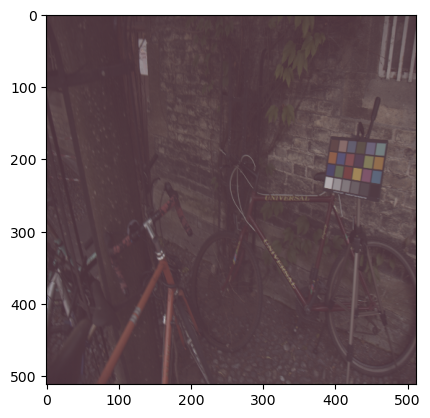

In [18]:
import matplotlib.pyplot as plt
plt.imshow(gt_img)

/Users/jyothivishnuvardhankolla/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


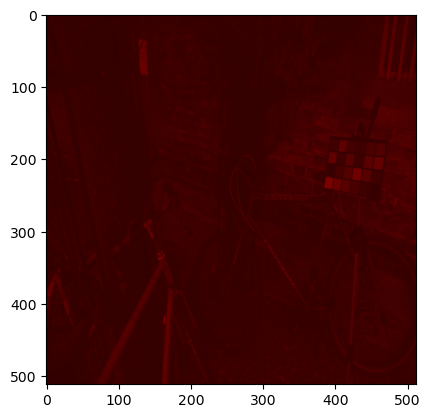

In [19]:
plt.imshow(cnn_img)